In [18]:
# Packages for loading, visualization, timing
from matplotlib import pyplot as plt
from timeit import default_timer
import pandas as pd

# Packages and functions for TopoAware
exec(open('topoaware.py').read())

# Load test data
data_raw = pd.read_csv('../examples/generated_data.csv')
data = data_raw[['x','y']].values

In [2]:
t0 = default_timer()

# Generate barycentric subdivision
print('Generating barycentric subdivision...',end=' ',flush=True)
radius_list = [0.1,0.2,0.25]
bs0 = data
bs1 = barycentric_subdivision(data, radius=radius_list[0], max_dim=2)
bs2 = barycentric_subdivision(data, radius=radius_list[1], max_dim=2)
bs3 = barycentric_subdivision(data, radius=radius_list[2], max_dim=2)

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Generating... done in 49.09 seconds


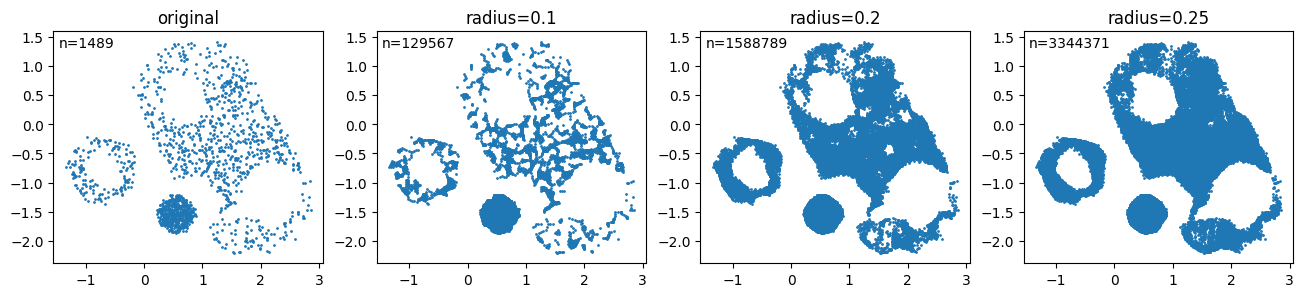

In [3]:
# Visualize barycentric subdivision
fig,axes = plt.subplots(1,4,figsize=(16,4))
radius_labels = ['original']+[f"radius={r}" for r in radius_list]
for ax,bs,title in zip(axes,[bs0,bs1,bs2,bs3],radius_labels):
    current_data = bs.T
    ax.scatter(current_data[0], current_data[1], s=1)
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.text(0.02,.98,f"n={current_data[0].shape[0]}",ha='left',va='top', transform=ax.transAxes)
plt.show()

In [5]:
t0 = default_timer()

# Generate sparsification
print('Generating sparsification...',end=' ',flush=True)
min_dist_list = [0.02,0.04,0.08]
sp_dict = {f"row{i}":[
    sparsification(bs0, min_dist=m),
    sparsification(bs1, min_dist=m),
    sparsification(bs2, min_dist=m),
    sparsification(bs3, min_dist=m)
] for i,m in enumerate(min_dist_list)
}

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Generating... done in 28.32 seconds


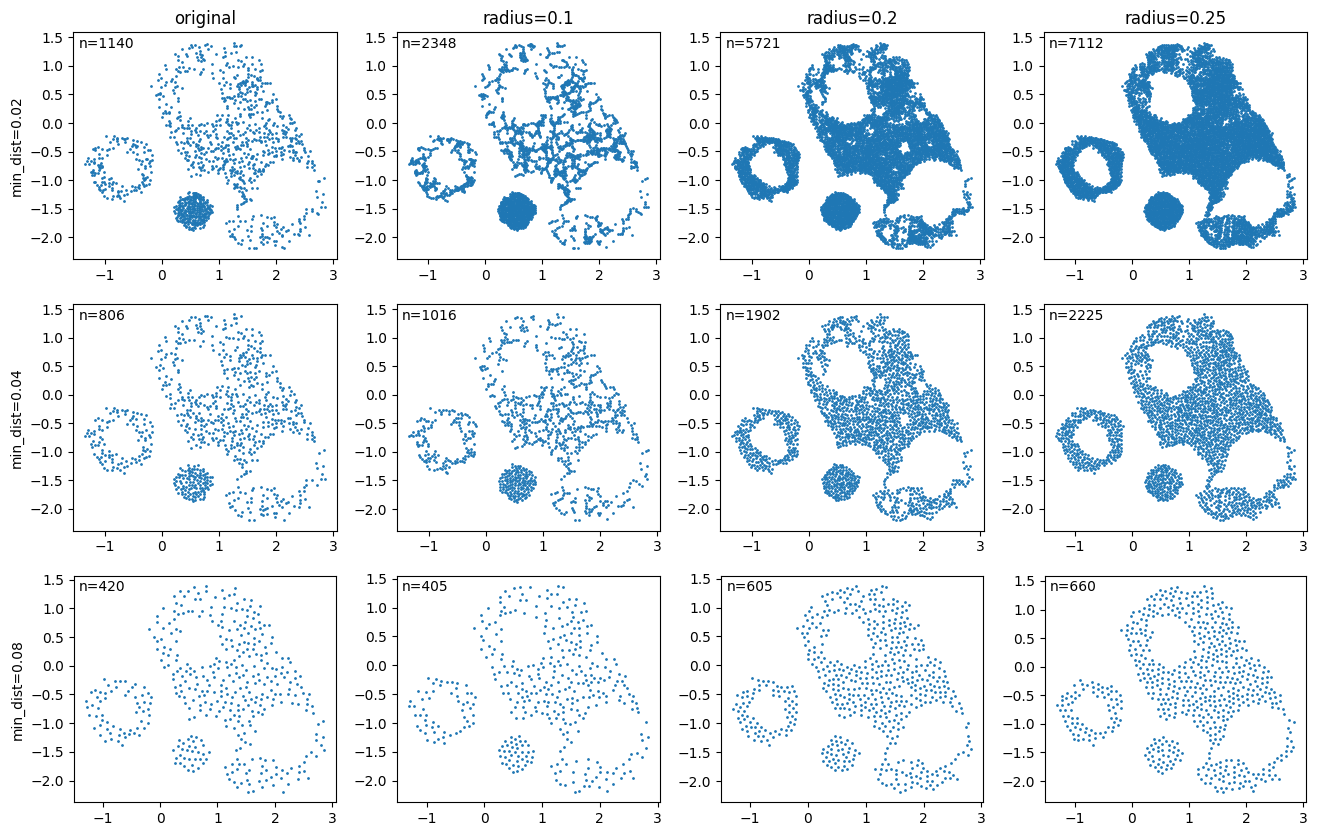

In [6]:
# Visualize sparsification
fig,axes = plt.subplots(3,4,figsize=(16,10))
min_dist_labels = [f"min_dist={m}" for m in min_dist_list]
for ax_row,sps,row_title in zip(axes,sp_dict,min_dist_labels):
    ax_row[0].set_ylabel(row_title)
    for ax,sp in zip(ax_row,sp_dict[sps]):
        current_data = sp.T
        ax.scatter(current_data[0], current_data[1], s=1)
        ax.set_aspect('equal')
        ax.text(0.02,.98,f"n={current_data[0].shape[0]}",ha='left',va='top', transform=ax.transAxes)
for col,col_title in enumerate(radius_labels):
    axes[0][col].set_title(col_title)
plt.show()

In [7]:
t0 = default_timer()

# Generate gridification
print('Generating grdification...',end=' ',flush=True)
gd_dict = {f"row{i}":[
    gridification(sp_dict[f"row{i}"][0], grid_interval=2*m, grid_origin=[0,0]),
    gridification(sp_dict[f"row{i}"][1], grid_interval=2*m, grid_origin=[0,0]),
    gridification(sp_dict[f"row{i}"][2], grid_interval=2*m, grid_origin=[0,0]),
    gridification(sp_dict[f"row{i}"][3], grid_interval=2*m, grid_origin=[0,0])
] for i,m in enumerate(min_dist_list)
}

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Generating... done in 0.08 seconds


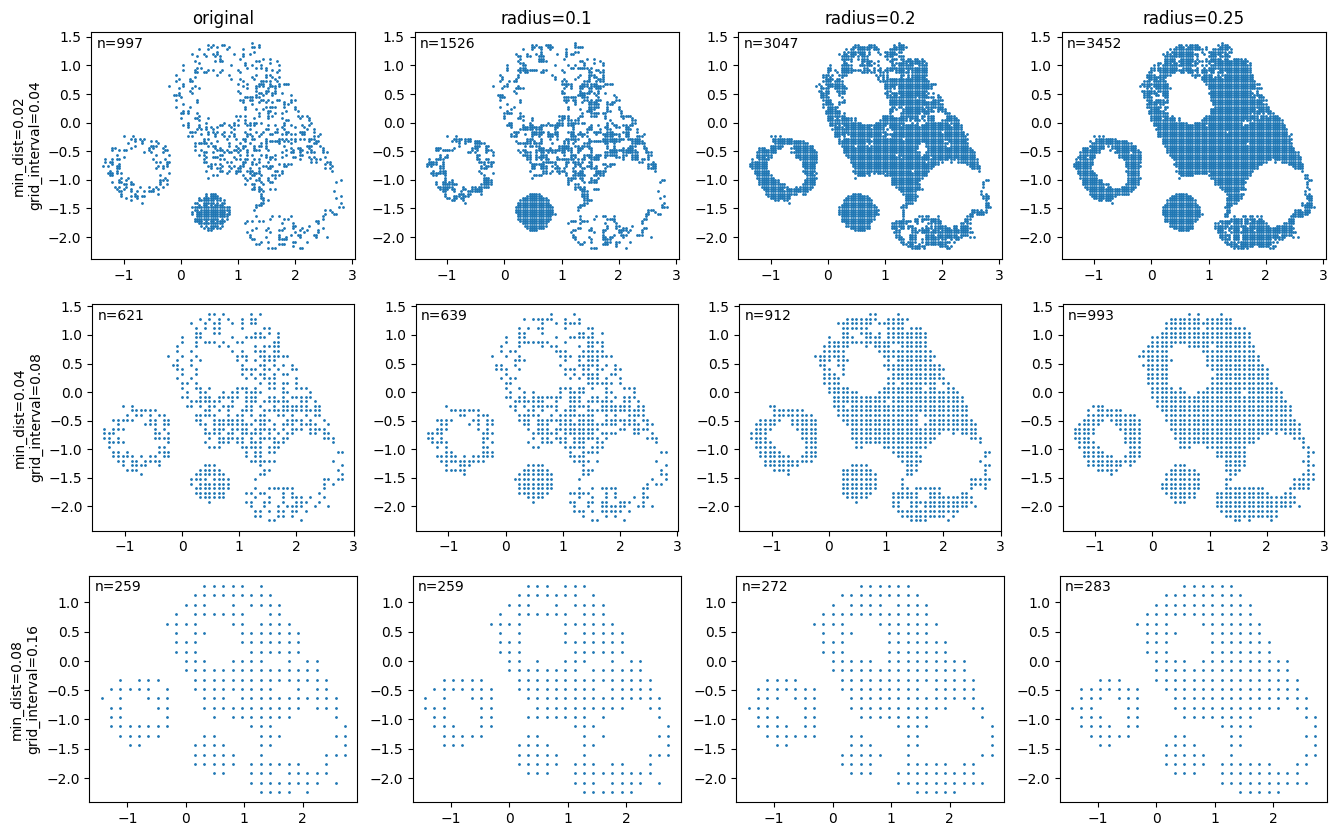

In [8]:
# Visualize gridification
fig,axes = plt.subplots(3,4,figsize=(16,10))
grid_interval_labels = [f"min_dist={m}\ngrid_interval={2*m}" for m in min_dist_list]
for ax_row,gds,row_title in zip(axes,gd_dict,grid_interval_labels):
    ax_row[0].set_ylabel(row_title)
    for ax,grid in zip(ax_row,gd_dict[gds]):
        current_data = grid.T
        ax.scatter(current_data[0], current_data[1], s=1)
        ax.set_aspect('equal')
        ax.text(0.02,.98,f"n={current_data[0].shape[0]}",ha='left',va='top', transform=ax.transAxes)
for col,col_title in enumerate(radius_labels):
    axes[0][col].set_title(col_title)
plt.show()

In [12]:
t0 = default_timer()

# Generate thickening (of gridification)
print('Generating thickening...',end=' ',flush=True)
th_dict = {f"row{i}":[
    thickening(gd_dict[f"row{i}"][0], grid_interval=2*m),
    thickening(gd_dict[f"row{i}"][1], grid_interval=2*m),
    thickening(gd_dict[f"row{i}"][2], grid_interval=2*m),
    thickening(gd_dict[f"row{i}"][3], grid_interval=2*m)
] for i,m in enumerate(min_dist_list)
}

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Generating... done in 0.42 seconds


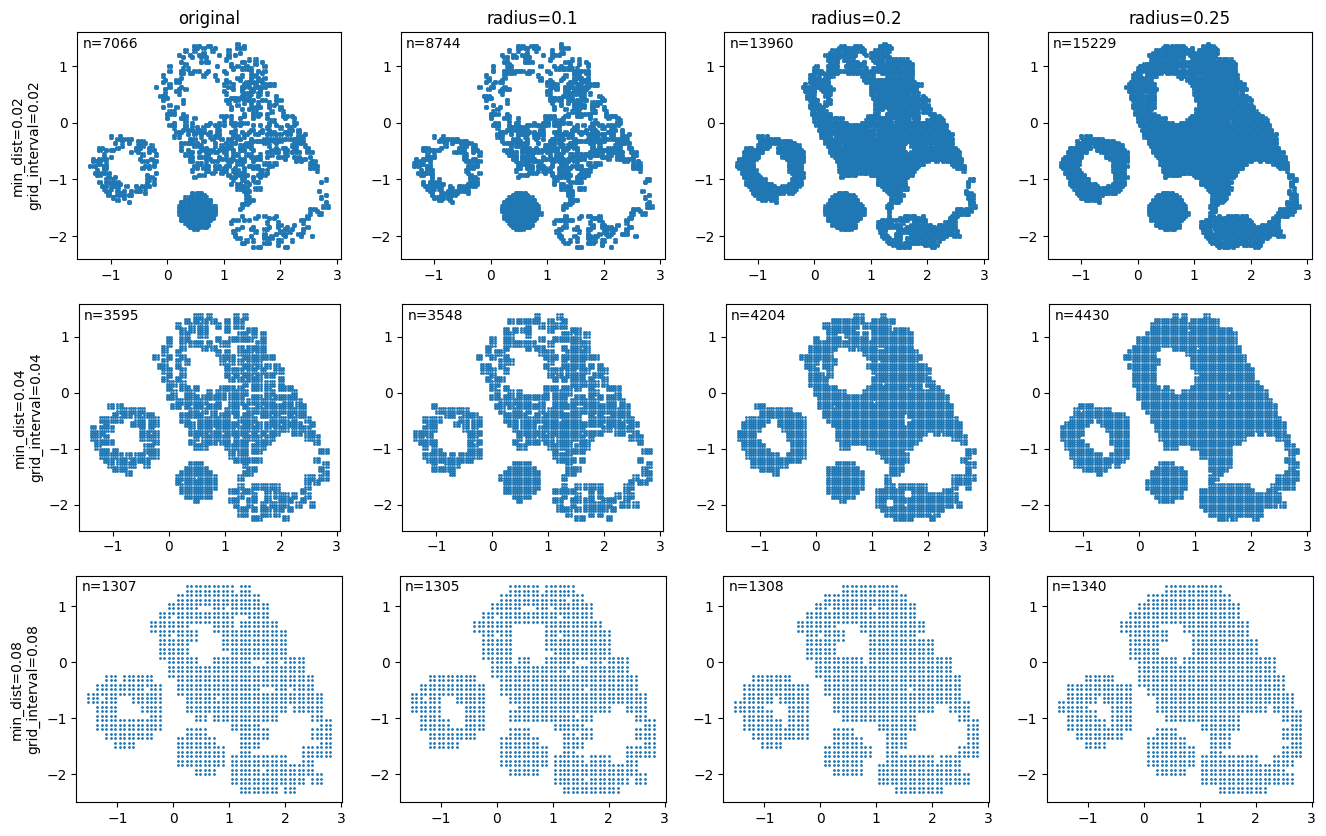

In [13]:
# Visualize thickening
fig,axes = plt.subplots(3,4,figsize=(16,10))
grid_interval_labels = [f"min_dist={m}\ngrid_interval={m}" for m in min_dist_list]
for ax_row,ths,row_title in zip(axes,th_dict,grid_interval_labels):
    ax_row[0].set_ylabel(row_title)
    for ax,th in zip(ax_row,th_dict[ths]):
        current_data = th.T
        ax.scatter(current_data[0], current_data[1], s=1)
        ax.set_aspect('equal')
        ax.text(0.02,.98,f"n={current_data[0].shape[0]}",ha='left',va='top', transform=ax.transAxes)
for col,col_title in enumerate(radius_labels):
    axes[0][col].set_title(col_title)
plt.show()

In [19]:
t0 = default_timer()

# Generate complement (of gridification)
print('Generating complement...',end=' ',flush=True)
co_dict = {f"row{i}":[
    complement(gd_dict[f"row{i}"][0], grid_interval=2*m, buffer=2),
    complement(gd_dict[f"row{i}"][1], grid_interval=2*m, buffer=2),
    complement(gd_dict[f"row{i}"][2], grid_interval=2*m, buffer=2),
    complement(gd_dict[f"row{i}"][3], grid_interval=2*m, buffer=2)
] for i,m in enumerate(min_dist_list)
}

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Generating complement... done in 0.19 seconds


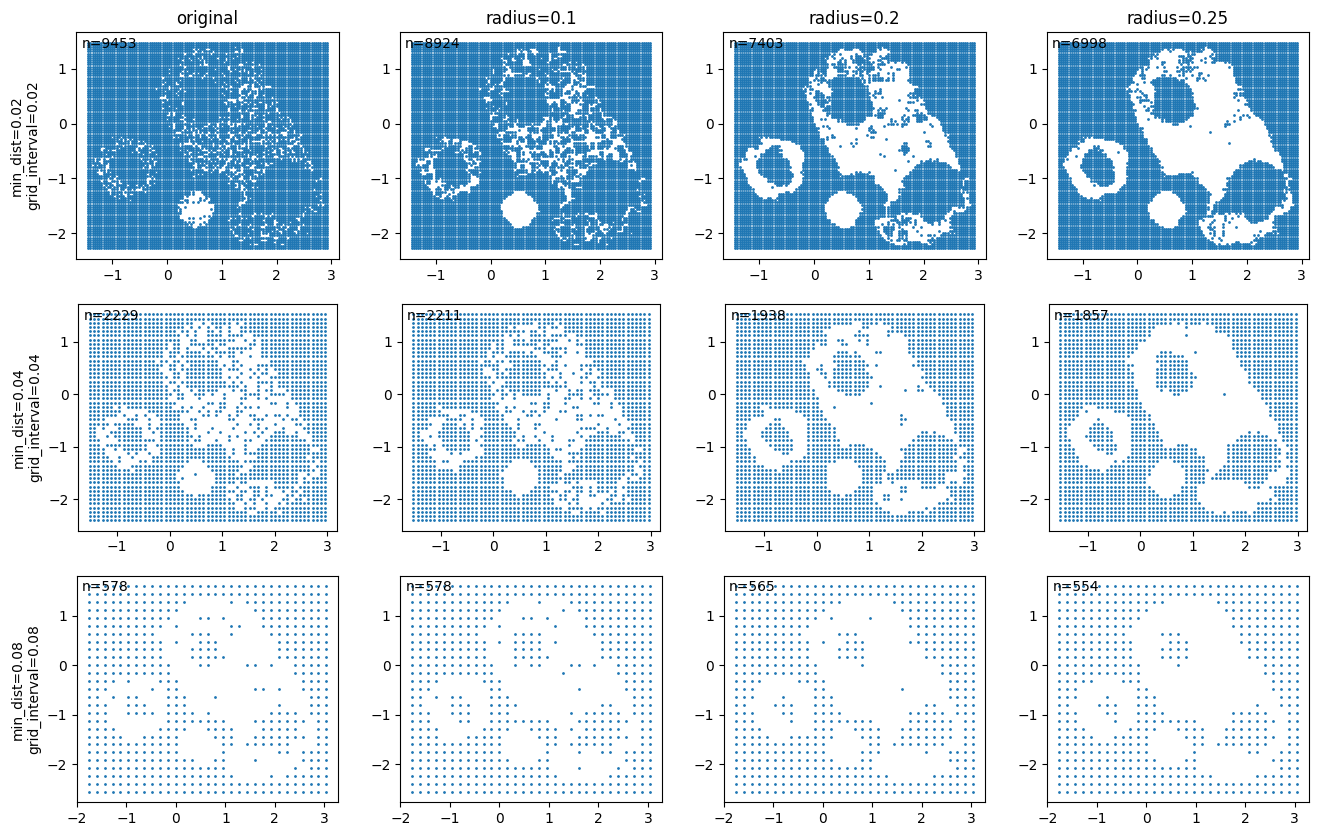

In [20]:
# Visualize complement
fig,axes = plt.subplots(3,4,figsize=(16,10))
grid_interval_labels = [f"min_dist={m}\ngrid_interval={m}" for m in min_dist_list]
for ax_row,cos,row_title in zip(axes,co_dict,grid_interval_labels):
    ax_row[0].set_ylabel(row_title)
    for ax,co in zip(ax_row,co_dict[cos]):
        current_data = co.T
        ax.scatter(current_data[0], current_data[1], s=1)
        ax.set_aspect('equal')
        ax.text(0.02,.98,f"n={current_data[0].shape[0]}",ha='left',va='top', transform=ax.transAxes)
for col,col_title in enumerate(radius_labels):
    axes[0][col].set_title(col_title)
plt.show()

In [26]:
t0 = default_timer()

# Generate Delaunay complex (of sparsification)
print('Generating Delaunay complex...',end=' ',flush=True)
dc_dict = {}
for i,m in enumerate(min_dist_list):
    row = f"row{i}"
    dc_container0 = gd.AlphaComplex(sp_dict[f"row{i}"][0]); dcc0 = dc_container0.create_simplex_tree()
    dc_container1 = gd.AlphaComplex(sp_dict[f"row{i}"][1]); dcc1 = dc_container1.create_simplex_tree()
    dc_container2 = gd.AlphaComplex(sp_dict[f"row{i}"][2]); dcc2 = dc_container2.create_simplex_tree()
    dc_container3 = gd.AlphaComplex(sp_dict[f"row{i}"][3]); dcc3 = dc_container3.create_simplex_tree()
    dc_dict[row] = [dcc0, dcc1, dcc2, dcc3]
    # dc_persistence = dcc0.persistence(homology_coeff_field=2, min_persistence=0)

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Generating Delaunay complex... done in 0.25 seconds


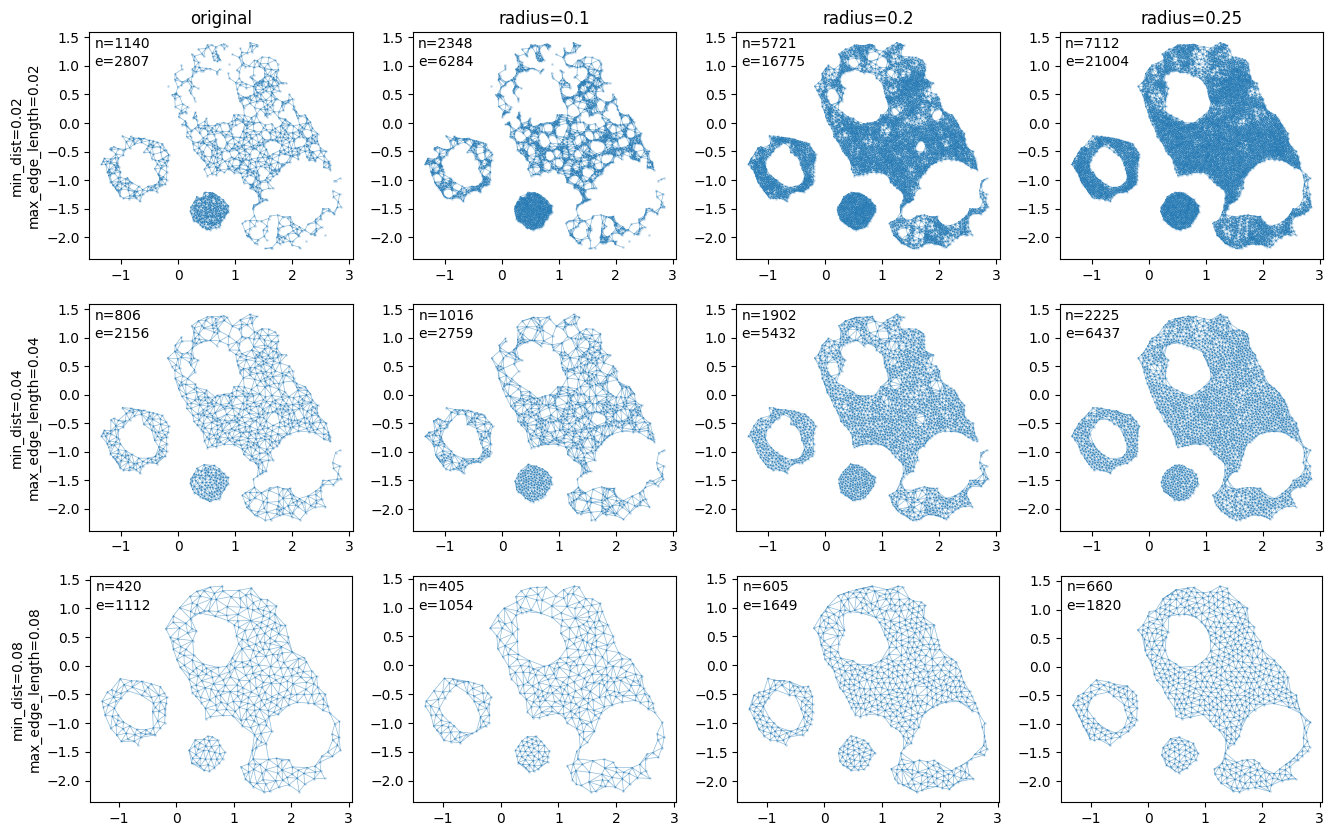

In [32]:
# Visualize alpha complex at fixed radius
fig,axes = plt.subplots(3,4,figsize=(16,10))
alpha_complex_labels = [f"min_dist={m}\nmax_edge_length={m}" for m in min_dist_list]
for ax_row,sps,dcs,m,row_title in zip(axes,sp_dict,dc_dict,min_dist_list,alpha_complex_labels):
    ax_row[0].set_ylabel(row_title)
    for ax,sp,dc in zip(ax_row,sp_dict[sps],dc_dict[dcs]):
        current_data = sp.T
        x = current_data[0]
        y = current_data[1]
        
        # vertices
        ax.scatter(x, y, s=1, alpha=.2)

        # edges
        ecount = 0; fcount = 0
        for s in dc.get_simplices():
            if len(s[0]) == 2:
                current_length = (x[s[0][0]]-x[s[0][1]])**2 + (y[s[0][0]]-y[s[0][1]])**2
                if current_length < m:
                    ax.plot([x[s[0][0]],x[s[0][1]]], [y[s[0][0]],y[s[0][1]]], c='C0', lw=.5, alpha=.5)
                    ecount += 1

        # style
        ax.set_aspect('equal')
        ax.text(0.02,.98,f"n={current_data[0].shape[0]}",ha='left',va='top', transform=ax.transAxes)
        ax.text(0.02,.9,f"e={ecount}",ha='left',va='top', transform=ax.transAxes)
        
for col,col_title in enumerate(radius_labels):
    axes[0][col].set_title(col_title)
plt.show()